# Introduction to OPR (Offensive Power Rating)

In FRC Robotics, OPR (Offensive Power Rating) is a metric used to estimate the average point contribution of each team to its alliance. It is calculated using linear algebra, specifically the least squares solution to an overdetermined system of equations. In this notebook, we will demonstrate the concept of OPR starting with a toy example with just one team in an alliance, and building on that to compute it for two or more teams per alliance.


# A Toy Example
Let's think about OPR in the case of a competition where each alliance consists of only one team.  In a perfectly predictable world, each single-team alliance scores exactly its OPR. e.g. here are some predicted outcomes for matches between three teams X, Y, and Z with OPRs x=10 y=15 z=20:

| Match | Alliance 1 | Alliance 2 | Predicted Score (Alliance 1) | Predicted Score (Alliance 2) |
|-------|--------|--------|--------------------------|--------------------------|
| 1     | X      | Y      | 10                       | 15                       |
| 2     | Y      | Z      | 15                       | 20                       |
| 3     | X      | Z      | 10                       | 20                       |

In this world we only need each team to compete once against the others. In fact if we know their OPR we don't need them to compete at all, since we can predict the outcome exactly.


However the real world is much less predictable, and an alliance's scores may vary from match to match.  Consider this situation instead:


| Match | Alliance 1 | Alliance 2 | Actual Score (Alliance 1) | Actual Score (Alliance 2) |
|-------|--------|--------|-----------------------|-----------------------|
| 1     | X      | Y      | 12                    | 14                    |
| 2     | Y      | Z      | 16                    | 18                    |
| 3     | X      | Z      | 11                    | 19                    |

In this setting it's less obvious what the OPR of each team is.  We want to compute a value for each team that minimizes the expected error in our prediction. In linear algebra this is known as least-squares minimization. Let's see how to do this in code:



In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the actual scores for the matches
data = {
    'Match': [1, 2, 3],
    'Alliance 1': ['X', 'Y', 'X'],
    'Alliance 2': ['Y', 'Z', 'Z'],
    'Actual Score (Alliance 1)': [12, 16, 11],
    'Actual Score (Alliance 2)': [14, 18, 19]
}

# Create a DataFrame to display the match data
df = pd.DataFrame(data)
df


,Match,Alliance 1,Alliance 2,Actual Score (Alliance 1),Actual Score (Alliance 2)
0,1,X,Y,12,14
1,2,Y,Z,16,18
2,3,X,Z,11,19


In [3]:
import numpy as np
import pandas as pd


# Create the matrix A and vector b for the least squares problem
teams = ['X', 'Y', 'Z']
num_teams = len(teams)
num_matches = len(df)

A = np.zeros((2 * num_matches, num_teams))
b = np.zeros(2 * num_matches)

team_index = {team: i for i, team in enumerate(teams)}

for i, row in df.iterrows():
    alliance1 = row['Alliance 1']
    alliance2 = row['Alliance 2']
    score1 = row['Actual Score (Alliance 1)']
    score2 = row['Actual Score (Alliance 2)']
    
    A[2 * i, team_index[alliance1]] = 1
    A[2 * i + 1, team_index[alliance2]] = 1
    b[2 * i] = score1
    b[2 * i + 1] = score2

# Solve the least squares problem
opr, _, _, _ = np.linalg.lstsq(A, b, rcond=None)

# Create a DataFrame to display the OPR results
opr_df = pd.DataFrame({'Team': teams, 'OPR': opr})
opr_df

,Team,OPR
0,X,11.5
1,Y,15.0
2,Z,18.5


If you are observant you may note that for the case where each alliance just has one team, a team's OPR is the average of its scores (its *expected* offensive power).

That was a lot of code to just compute some averages but we are setting up the problem for when we have two or three (or more) teams in each alliance. Let's see how the matrix A was constructed:

In [4]:
A

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

Each pair of rows in A corresponds to a match, and each column corresponds to a team.  Row (2m) indicates the composition of Alliance 1 in match m while row (2m+1) indicates the composition of the Alliance 2.  So for example, we see that match 2 Alliance 2 is composed of [0, 0, 1], or Team Z.

<table>
  <tr>
    <th>Match</th>
    <th>Alliance</th>
    <th>X</th>
    <th>Y</th>
    <th>Z</th>
  </tr>
  <tr>
    <td rowspan="2">1</td>
    <td>1</td>
    <td>1</td>
    <td>0</td>
    <td>0</td>
  </tr>
  <tr>
    <td>2</td>
    <td>0</td>
    <td>1</td>
    <td>0</td>
  </tr>
  <tr>
    <td rowspan="2">2</td>
    <td>1</td>
    <td>0</td>
    <td>1</td>
    <td>0</td>
  </tr>
  <tr>
    <td>2</td>
    <td>0</td>
    <td>0</td>
    <td>1</td>
  </tr>
  <tr>
    <td rowspan="2">3</td>
    <td>1</td>
    <td>1</td>
    <td>0</td>
    <td>0</td>
  </tr>
  <tr>
    <td>2</td>
    <td>0</td>
    <td>0</td>
    <td>1</td>
  </tr>
</table>

Likewise the vector b consists of the scores of each match with element (2m) indicating Alliance 1's score and element (2m+1) indicating Alliance 2's score. 


<table>
  <tr>
    <th>Match</th>
    <th>Alliance</th>
    <th>Score</th>
  </tr>
  <tr>
    <td rowspan="2">1</td>
    <td>1</td>
    <td>12</td>
  </tr>
  <tr>
    <td>2</td>
    <td>14</td>
  </tr>
  <tr>
    <td rowspan="2">2</td>
    <td>1</td>
    <td>16</td>
  </tr>
  <tr>
    <td>2</td>
    <td>18</td>
  </tr>
  <tr>
    <td rowspan="2">3</td>
    <td>1</td>
    <td>11</td>
  </tr>
  <tr>
    <td>2</td>
    <td>19</td>
  </tr>
</table>

Finally, the call `np.linalg.lstsq(A,b,rcond=None)` sets up and calculates the solution to the system of equations A*x*=b where x here is the unknown OPR vector *x*=[x,y,z] (don't be confused by *x* vs x -- the former is the vector of all unknown OPR scores and the latter is the OPR of team X).

Note that this is a system of six equations with only three unknowns. As such it is overdetermined and the least squares solution computed by `np.linalg.lstsq` minimizes our prediction error when the alliances don't perform exactly to their OPR expectations.

# Extending to two teams per alliance

Now let's consider the case where an alliance consists of two teams. We will add Team W to our pool so we have four teams competing against one another.  

It's tempting to set up the problem to just have alliance {W,X} play alliance {Y,Z} several times and compute the OPR from the results but this creates a problem. If W only ever competes in a team with X, we can compute the alliance's OPR but we can never differentiate between the individual contributions of W and X. Instead we are reliant on scheduling several matches where the alliances rotate. Let's construct some matches and compute the OPR:


| Match | Alliance 1 | Alliance 2 | Actual Score (Alliance 1) | Actual Score (Alliance 2) |
|-------|------------|------------|---------------------------|---------------------------|
| 1     | W, X       | Y, Z       | 25                        | 30                        |
| 2     | W, Y       | X, Z       | 20                        | 28                        |
| 3     | W, Z       | X, Y       | 22                        | 26                        |
| 4     | X, Y       | W, Z       | 24                        | 27                        |
| 5     | X, Z       | W, Y       | 23                        | 29                        |
| 6     | Y, Z       | W, X       | 21                        | 31                        |

In [5]:

# Define the actual scores for the matches
data = {
    'Match': [1, 2, 3, 4, 5, 6],
    'Alliance 1': ['W, X', 'W, Y', 'W, Z', 'X, Y', 'X, Z', 'Y, Z'],
    'Alliance 2': ['Y, Z', 'X, Z', 'X, Y', 'W, Z', 'W, Y', 'W, X'],
    'Actual Score (Alliance 1)': [25, 20, 22, 24, 23, 21],
    'Actual Score (Alliance 2)': [30, 28, 26, 27, 29, 31]
}

# Create a DataFrame to display the match data
df = pd.DataFrame(data)

# Create the matrix A and vector b for the least squares problem
teams = ['W', 'X', 'Y', 'Z']
num_teams = len(teams)
num_matches = len(df)

A = np.zeros((2 * num_matches, num_teams))
b = np.zeros(2 * num_matches)

team_index = {team: i for i, team in enumerate(teams)}

for i, row in df.iterrows():
    alliance1 = row['Alliance 1'].split(', ')
    alliance2 = row['Alliance 2'].split(', ')
    score1 = row['Actual Score (Alliance 1)']
    score2 = row['Actual Score (Alliance 2)']
    
    for team in alliance1:
        A[2 * i, team_index[team]] = 1
    for team in alliance2:
        A[2 * i + 1, team_index[team]] = 1
    b[2 * i] = score1
    b[2 * i + 1] = score2

# Solve the least squares problem
opr, _, _, _ = np.linalg.lstsq(A, b, rcond=None)

# Create a DataFrame to display the OPR results
opr_df = pd.DataFrame({'Team': teams, 'OPR': opr})
opr_df

,Team,OPR
0,W,13.00
1,X,13.75
2,Y,12.00
3,Z,12.25


For illustration, here is matrix A and vector b:

In [6]:
A, b

(array([[1., 1., 0., 0.],
        [0., 0., 1., 1.],
        [1., 0., 1., 0.],
        [0., 1., 0., 1.],
        [1., 0., 0., 1.],
        [0., 1., 1., 0.],
        [0., 1., 1., 0.],
        [1., 0., 0., 1.],
        [0., 1., 0., 1.],
        [1., 0., 1., 0.],
        [0., 0., 1., 1.],
        [1., 1., 0., 0.]]),
 array([25., 30., 20., 28., 22., 26., 24., 27., 23., 29., 21., 31.]))

Note in this case we have 12 equations of 4 unknowns and again the system is overdetermined. In fact we could have estimated OPR with results from just two matches (four equations), for example {W,X} vs {Y,Z} and {W,Y} vs {X,Z}.

It is also useful for us to understand the residuals in our OPR estimates.  This is simply A*opr-b (in numpy '@' is the operator for matrix multiplication):

In [7]:
A@opr-b

array([ 1.75, -5.75,  5.  , -2.  ,  3.25, -0.25,  1.75, -1.75,  3.  ,
       -4.  ,  3.25, -4.25])

And finally, we can estimate the uncertainty in our estimates. These are useful for computing an expected range of scores. In the code below, the `sigmas` vector represents the expected error (standard deviation) around each team's OPR:

In [9]:
opr, residual, rank, s = np.linalg.lstsq(A, b, rcond=None)
RSS = residual.sum()
Rinv = np.linalg.inv(np.triu(np.diag(s)))

sigmas = np.sqrt(RSS / (len(b) - len(opr)) * np.diag(Rinv))
sigmas


array([2.2112067 , 2.91011168, 2.91011168, 2.91011168])

# Visualize the Results
Armed with OPR and sigma we can estimate the range of possible offensive power of any alliance. For example, here's a visualization of an alliance composed of {W,X,Y}:

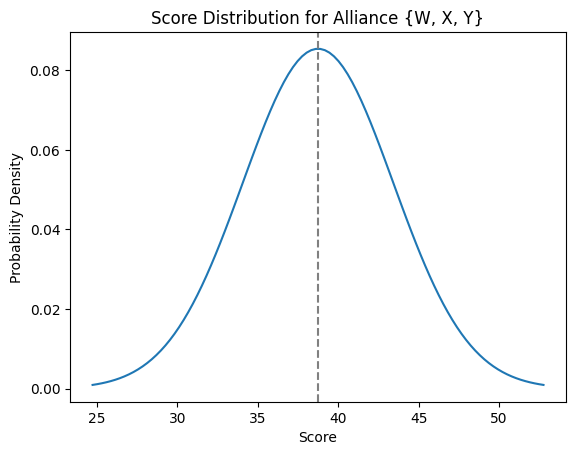

In [10]:
from scipy.stats import norm
import matplotlib.pyplot as plt

# Compute the OPR and sigma for the alliance {W, X, Y}
alliance_opr = opr[team_index['W']] + opr[team_index['X']] + opr[team_index['Y']]
alliance_sigma = np.sqrt(sigmas[team_index['W']]**2 + sigmas[team_index['X']]**2 + sigmas[team_index['Y']]**2)

# Generate a plot showing the corresponding Gaussian distribution
x = np.linspace(alliance_opr - 3*alliance_sigma, alliance_opr + 3*alliance_sigma, 100)
y = norm.pdf(x, alliance_opr, alliance_sigma)

plt.plot(x, y, label='Gaussian Distribution')
plt.axvline(alliance_opr, color='gray', linestyle='--', label='Mean OPR')
plt.xlabel('Score')
plt.ylabel('Probability Density')
plt.title('Score Distribution for Alliance {W, X, Y}')
plt.show()

So from this calculation we expect {W,X,Y} to score `alliance_opr` with standard deviation given by `alliance_sigma`:

In [31]:
(alliance_opr,alliance_sigma)

(38.75000000000001, 4.6719305530154935)

It is straightforward to extend the calculation of OPR to alliances consisting of three teams (or even more).  It is also worth thinking about how we might calculate a "Defensive Power Rating" or DPR. Consider: is OPR enough to predict a match outcome? If it's possible to compute a DPR maybe we want to take that into account.  More generally, we could estimate the "Total Power Rating" as a team's expected contribution to a match's point spread, rather than their total score.  Thus a team may have an positive or negative TPR, depending on how often they come out on the winning or losing side.

## Limitations

OPR has its limitations. FRC outcomes are due to the complex interactions of the robots on the field and sometimes involve strategic tradeoffs. As such it's unlikely that putting the robots with the top three OPRs on the field will yield a total score close to their sum (at some point in the game, scoring capacity may saturate, no matter how powerful the alliance is). However for comparison purposes and for alliance selection, OPR, or even better TPR, can be a valuable statistic to have in your back pocket.